In [1]:
%matplotlib inline
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import model_to_dot
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import os
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class vpn_mnist_config:
    def __init__(self):
        pass
    data_dir = os.path.join(os.path.expanduser('~/Data/mnist_test_seq.npy'))
    train_sequences_num = 7000
    truncated_steps = 9
    batch_size = 4
    num_timestamps = 10

In [3]:
class GenerateMovingMnistData:
    def __init__(self):
        np.random.seed(123)
        sequences = np.load(vpn_mnist_config.data_dir).transpose((1, 0, 2, 3))
        sequences = np.expand_dims(np.squeeze(sequences), 4)
        shuffled_idxs = np.arange(sequences.shape[0])
        np.random.shuffle(shuffled_idxs)
        sequences = sequences[shuffled_idxs]

        self.num_timestamps = 10
        self.height = sequences.shape[2]
        self.width = sequences.shape[3]
        self.channel = sequences.shape[4]
        self.batch_size = vpn_mnist_config.batch_size
        self.seq_len = sequences.shape[0]
        self.train_len = vpn_mnist_config.train_sequences_num
        assert self.train_len < self.seq_len
        self.test_len = self.seq_len - self.train_len

        self.train_sequences = sequences[:self.train_len]
        self.test_sequences = sequences[self.train_len:]

    def next_train_batch_keras(self):
        while True:
            for i in range(0, self.train_len, self.batch_size):
                for j in range(i, i+self.batch_size):
                    idx = np.random.choice(self.train_len, self.batch_size)
                    current_sequence = self.train_sequences[idx]
                    current_sequence = current_sequence / 255.0
                # 输入前面10帧，以及预测的后面10帧
                prev_data = current_sequence[:, 0:self.num_timestamps]
                future_data = current_sequence[:, 1:self.num_timestamps+1]
                yield prev_data, future_data

    def next_test_batch_keras(self):
        while True:
            for i in range(0, self.test_len, self.batch_size):
                for j in range(i, i+self.batch_size):
                    idx = np.random.choice(self.test_len, self.batch_size)
                    current_sequence = self.test_sequences[idx]
                    current_sequence = current_sequence / 255.0
                # 输入前面10帧，以及预测的后面10帧
                prev_data = current_sequence[:, 0:self.num_timestamps]
                future_data = current_sequence[:, 1:self.num_timestamps+1]
                yield prev_data, future_data

    def test_batch(self):
        while True:
            idx = np.random.choice(self.test_sequences.shape[0], self.batch_size)
            current_sequence = self.test_sequences[idx]

            # 输入前面10帧，以及预测的后面10帧
            return current_sequence[:, 0:self.num_timestamps]

In [4]:
data_generate = GenerateMovingMnistData()

In [5]:
n_frames = data_generate.num_timestamps
row = data_generate.height
col = data_generate.width
channel = data_generate.channel
batch_size = data_generate.batch_size

In [6]:
model = Sequential()
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), input_shape=(n_frames, row, col, channel), padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(ConvLSTM2D(filters=40, kernel_size=(3, 3), padding='same', return_sequences=True))
model.add(BatchNormalization())
model.add(Conv3D(filters=1, kernel_size=(1, 3, 3), activation='sigmoid', padding='same', data_format='channels_last'))
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 64, 64, 40)    59200     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 64, 64, 40)    160       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 64, 64, 40)    115360    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 64, 64, 40)    160       
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 10, 64, 64, 40)    115360    
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 64, 64, 40)    160       
_________________________________________________________________
conv_lst_m2d_4 (ConvLSTM2D)  (None, 10, 64, 64, 40)    115360    
__________

In [8]:
callbacks = []
model_checkpoint_filepath = "keras_conv_lstm_weights_best.hdf5"
if os.path.exists(model_checkpoint_filepath):
    model.load_weights(model_checkpoint_filepath)
model_checkpoint = ModelCheckpoint(filepath=model_checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks.append(model_checkpoint)

In [9]:
# model.fit_generator(generator=data_generate.next_train_batch_keras(), validation_data=data_generate.next_test_batch_keras(), steps_per_epoch=data_generate.train_len / batch_size, validation_steps=data_generate.test_len / batch_size, epochs=1000, verbose=1, callbacks=callbacks)

In [10]:
# model.predict(np.array(data_generate.next_batch()))
data_sample_test = np.array(data_generate.test_batch())/255.0
data_sample_test_pred = model.predict(data_sample_test)

In [11]:
data_sample_test_pred.shape

(4, 10, 64, 64, 1)

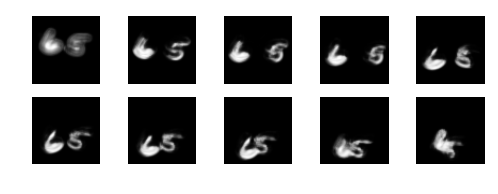

In [12]:
for image_index in range(vpn_mnist_config.num_timestamps):
    img = data_sample_test_pred[0, image_index, :, :, 0]
    plt.subplot(4, 5, image_index+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')